In [1]:
# Class label csv path
labels_csv_path = 'datasets/home_labels.csv'
# output result csv path
output_vclip_path = 'outputs/vclip_results.csv'
output_clap_path = 'outputs/clap_results.csv'

### Load Data from CSV

In [2]:
import csv
import numpy as np

label2id = {}
id2label = {}
with open(labels_csv_path, mode='r') as file:
    csv_reader = csv.reader(file)

    for i, row in enumerate(csv_reader):
        class_name = row[0]
        label2id[class_name] = i
        id2label[i] = class_name

class_labels = list(label2id.keys())

print(f"{len(class_labels)} Unique classes: {class_labels}.")

70 Unique classes: ['No people is in the room', 'Studying', 'Typing', 'Using computer', 'Making phone calls', 'Play with phone/tablet', 'Playing with pets', 'Sitting down', 'Reading', 'Writing', 'Setting table', 'Eating food', 'Dining', 'Cooking', 'Sleeping', 'Laying down', 'Picking up objects', 'Brushing teeth', 'Showering', 'Playing music', 'TV', 'Cleaning', 'Doing laundry', 'Mopping floor', 'Vacumning', 'Organizing space', 'Sewing', 'Knitting', 'Decorating', 'Party', 'Chatting', 'Talking', 'Singing', 'Laughing', 'Speaking', 'Dancing', 'Drinking', 'Meditating', 'Drawing', 'Painting', 'Playing board games', 'Playing video games', 'Taking photos', 'Potluck', 'Working', 'Exercising', 'Walking', 'Running', 'Celebrating', 'Physical altercations', 'Verbal confrontations', 'Using drug', 'Theft or vandalism', 'Fighting', 'Domestic violence', 'Break in', 'Glass breaking', 'Unattended cooking', 'Smoke or Fire or Open flame', 'Smoking', 'Gunshot', 'Making noise', 'Falling down', 'Tripping', 'Cr

In [3]:
import csv

def read_results(csv_path):
    results = []
    labels = []
    with open(csv_path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)

        for row in csv_reader:
            file_name, label, top1_pred, top1_conf, top2_pred, top2_conf, top3_pred, top3_conf, top4_pred, top4_conf, top5_pred, top5_conf = row
            labels.append(label)
            results.append([top1_pred, top1_conf, top2_pred, top2_conf, top3_pred, top3_conf, top4_pred, top4_conf, top5_pred, top5_conf])

    results = np.asarray(results).astype(float)
    labels  = np.asarray(labels).astype(int)
    return results, labels

In [4]:
vclip_results, vclip_labels = read_results(output_vclip_path)
clap_results, clap_labels = read_results(output_clap_path)

In [5]:
print(vclip_results.shape, vclip_labels.shape)
print(clap_results.shape, clap_labels.shape)
print(sum(vclip_labels == clap_labels))
print(vclip_results)
print(vclip_labels)

(424, 10) (424,)
(424, 10) (424,)
424
[[6.40000e+01 9.86816e+01 6.60000e+01 ... 9.80000e-02 6.70000e+01
  4.93000e-02]
 [6.40000e+01 9.43359e+01 1.40000e+01 ... 2.48900e-01 3.30000e+01
  1.87900e-01]
 [6.40000e+01 9.84375e+01 3.30000e+01 ... 7.92000e-02 5.00000e+01
  6.47000e-02]
 ...
 [5.80000e+01 5.86914e+01 5.50000e+01 ... 3.41490e+00 6.70000e+01
  3.36300e+00]
 [5.80000e+01 5.59082e+01 5.20000e+01 ... 2.96330e+00 5.50000e+01
  2.11790e+00]
 [5.80000e+01 2.98096e+01 6.70000e+01 ... 2.81680e+00 5.70000e+01
  2.72980e+00]]
[64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 60 60 60 60 60 60 60 60 60 60 60
 60 60 60 60 60 60 60 60 60 60 6

# Train

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.inspection import permutation_importance


# kf = KFold(n_splits=50)

X = np.hstack([vclip_results, clap_results])
assert np.array_equal(vclip_labels, clap_labels)
y = np.array(vclip_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

classifiers = [
               SVC(kernel='poly'),
               KNeighborsClassifier(),
               KNeighborsClassifier(n_neighbors=12),
               RandomForestClassifier(),
               RandomForestClassifier(criterion='entropy'),
               RandomForestClassifier(criterion='log_loss'),
               RandomForestClassifier(n_estimators=50, criterion='entropy'),
               RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=5)
            ]

print("Accuracy for")
all_accuracies = []
for clf_model in classifiers:
    # accuracy = []
    # for train_index, test_index in kf.split(X):
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = Y[train_index], Y[test_index]
    #     clf_model.fit(X_train, y_train)
    #     accuracy.append(clf_model.score(X_test, y_test))

    # print("%s: %.2f%%" % (clf_model, np.mean(accuracy) * 100))
    # all_accuracies.append(np.mean(accuracy))

    clf_model.fit(X_train, y_train)
    accuracy = clf_model.score(X_test, y_test)
    print("%s: %.2f%%" % (clf_model, accuracy * 100))
    all_accuracies.append(accuracy)

    

print("Average accuracy across", len(classifiers), "ML models is %.2f%%" % (np.mean(all_accuracies) * 100))



Accuracy for
SVC(kernel='poly'): 74.53%
KNeighborsClassifier(): 86.79%
KNeighborsClassifier(n_neighbors=12): 83.02%
RandomForestClassifier(): 92.45%
RandomForestClassifier(criterion='entropy'): 90.57%
RandomForestClassifier(criterion='log_loss'): 89.62%
RandomForestClassifier(criterion='entropy', n_estimators=50): 92.45%
RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30): 86.79%
Average accuracy across 8 ML models is 87.03%


In [12]:
selected = 3
selected_model = classifiers[selected]

y_pred = selected_model.predict(X_test)


In [21]:
import joblib

# Save the model to a file
joblib.dump(selected_model, 'trained_RF_ensemble.joblib')

['trained_RF_ensemble.joblib']

In [13]:
print(y_pred)


[69 69 64 58 69 69 62 60 56 64 69 56 64 69 69 60 60 69 56 62 56 60 64 69
 69 64 60 69 69 69 62 56 62 69 62 69 69 69 69 56 60 69 60 69 69 58 56 56
 64 69 64 62 58 69 56 58 60 56 69 69 60 69 56 62 69 64 62 64 69 58 69 58
 69 69 69 69 58 69 69 56 58 69 60 69 69 69 56 69 69 58 69 69 62 64 69 56
 69 56 69 58 69 56 69 69 58 69]


# Per-class Accuracy

In [14]:
from collections import defaultdict

correct = defaultdict(int)
total = defaultdict(int)
for i, label in enumerate(y_test):
    total[label] += 1
    if label == y_pred[i]:
        correct[label] += 1
        
for label in total:
    print(f"{id2label[label]}: {correct[label]} / {total[label]}")

Smoke or Fire or Open flame: 11 / 13
Normal: 46 / 48
Crying: 9 / 9
Gunshot: 9 / 9
Glass breaking: 16 / 18
Falling down: 7 / 9


In [15]:
for i, label in enumerate(y_test):
    if id2label[label] == "Normal":
        pred = y_pred[i]
        print(id2label[pred])

Normal
Normal
Normal
Falling down
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Falling down
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


# Feature Importance

Feature importance for RandomForestClassifier() is [0.03757862 0.00660377 0.         0.00023585 0.         0.
 0.         0.         0.00086478 0.         0.04386792 0.
 0.00117925 0.         0.00031447 0.00117925 0.         0.00283019
 0.00110063 0.00542453]


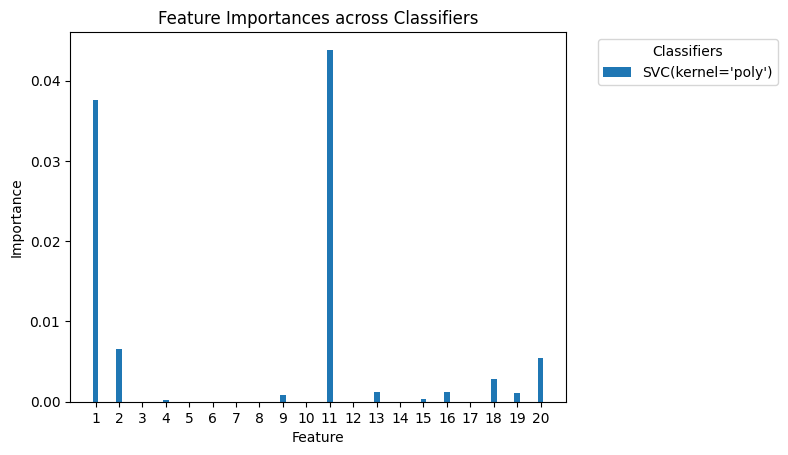

In [19]:
import matplotlib.pyplot as plt 

# feature permutation importance
feature_names = list(range(1, 21))

all_importances = []
for clf_model in [classifiers[selected]]:
    importance = permutation_importance(clf_model, X_train, y_train, n_repeats=40, random_state=0)
    all_importances.append(importance.importances_mean)
    print("Feature importance for", clf_model, "is", importance.importances_mean)

all_importances = np.array(all_importances)

# Plot 
num_classifiers, num_features = all_importances.shape
bar_width = 0.25  # Width of the bars
x_indices = np.arange(num_features)  # X-axis positions for the bars

# Create a bar for each classifier
for i in range(num_classifiers):
    bars = plt.bar(x_indices + i * bar_width, all_importances[i], width=bar_width, label=str(classifiers[i]))
    # Add rankings
    rankings_id = np.argsort(all_importances[i])[::-1]
    rankings = np.zeros(num_features)
    for i, rank in enumerate(rankings_id):
        rankings[rank] = i

    # for bar, ranking in zip(bars, rankings):
    #     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'#{int(ranking + 1)}', ha='center', va='bottom')

# Labels and Legend
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances across Classifiers')
plt.xticks(x_indices + bar_width * (num_classifiers - 1) / 2, feature_names)
plt.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()